2025-05-19 17:25:45,435 - INFO - Loading HierarchicalCtcMultiScaleOcrModel from: ./vnhwt-hierarchical-transformer-ctc-opt2-1405
2025-05-19 17:25:45,436 - WARNING - Combined character vocabulary is empty during config init.
2025-05-19 17:25:45,436 - INFO - Loaded config from file, applied/overrode with kwargs: {}
2025-05-19 17:25:45,437 - INFO - Converted vision_encoder_config dict to ViTConfig object.
2025-05-19 17:25:45,437 - INFO - Initializing HierarchicalCtcMultiScaleOcrModel with config: hierarchical_ctc_transformer
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 

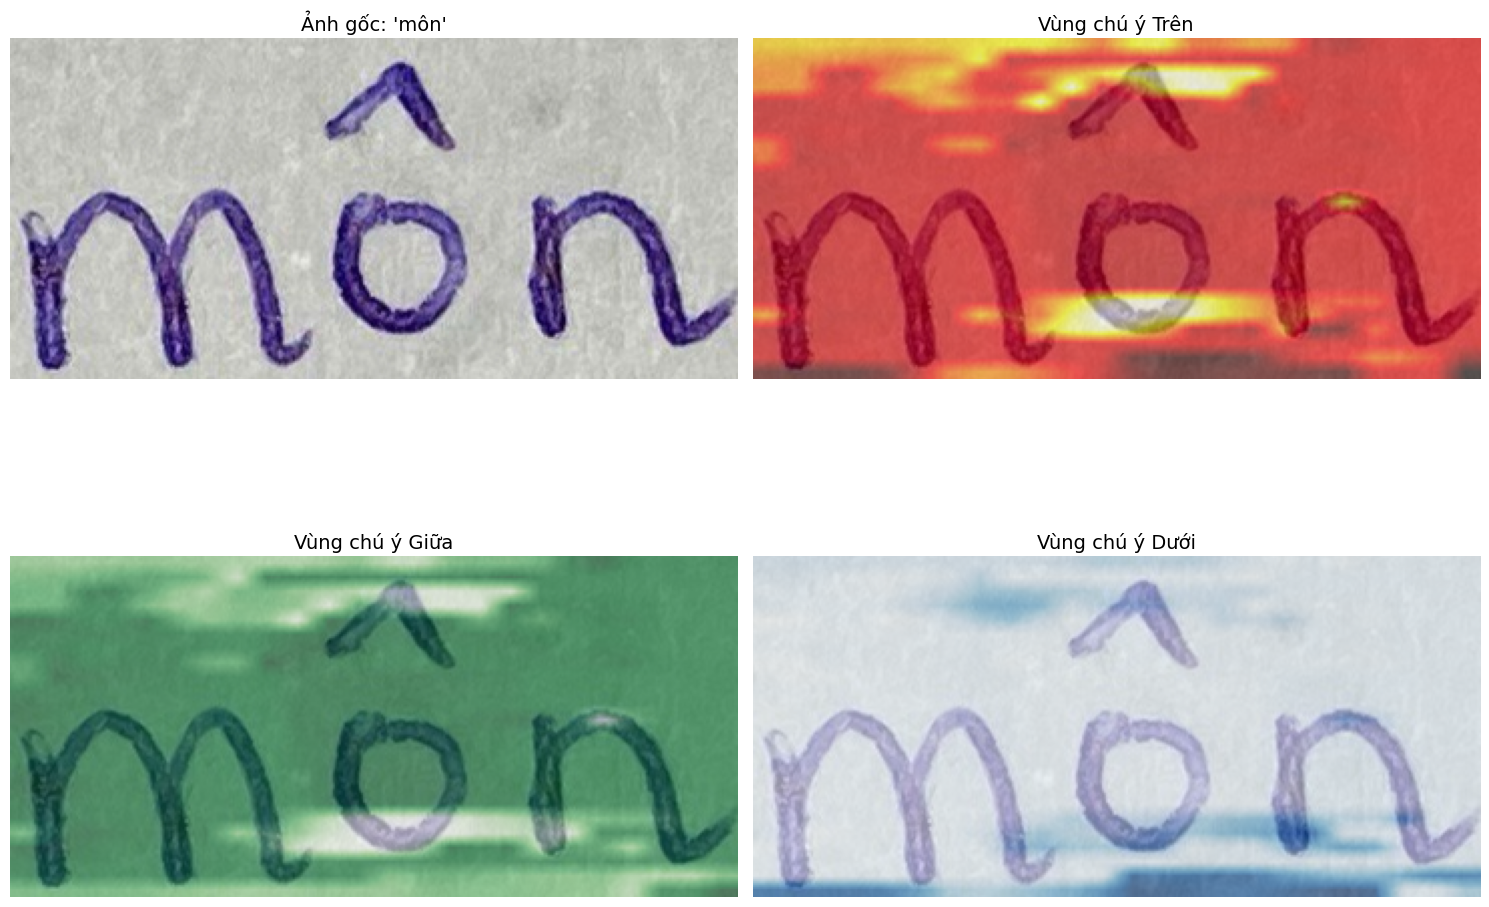

2025-05-19 17:25:52,640 - INFO - Đã lưu bản đồ chú ý kết hợp vào output_visualizations/diacritic_attention_combined.png


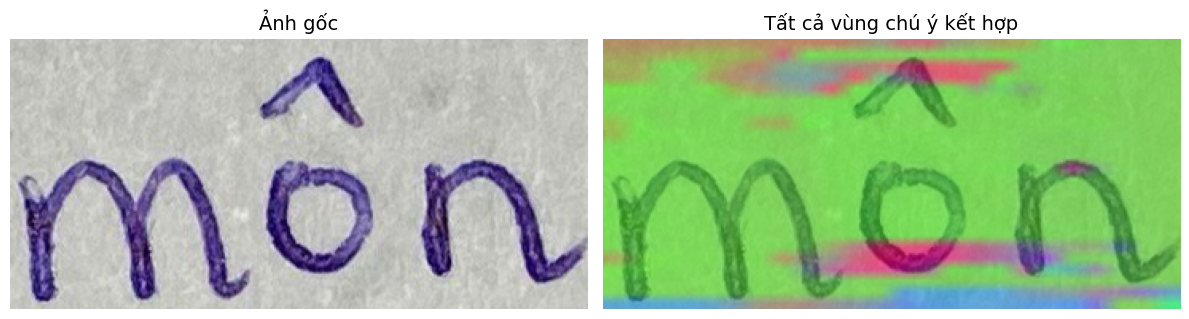

2025-05-19 17:25:52,779 - INFO - Đã lưu biểu đồ trọng số chú ý vào output_visualizations/diacritic_attention_weights.png


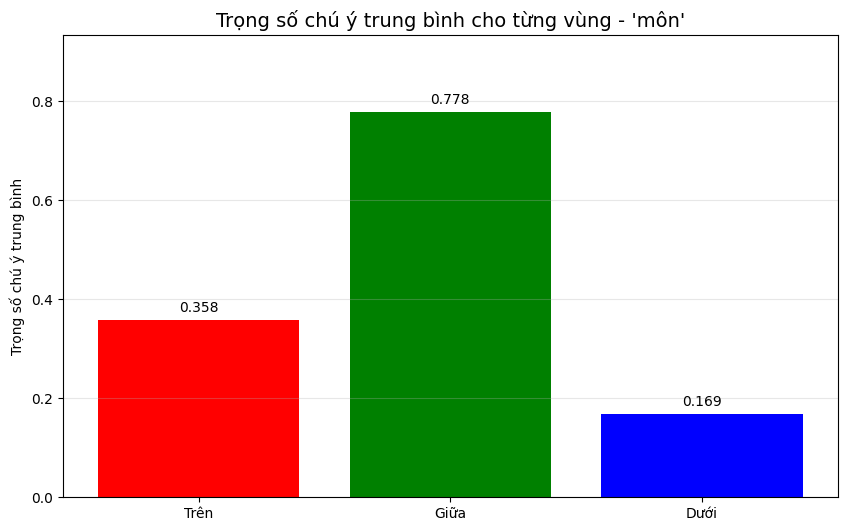

2025-05-19 17:25:52,852 - INFO - Đã lưu biểu đồ trọng số chú ý cho từng ký tự vào output_visualizations/char_diacritic_attention_weights.png


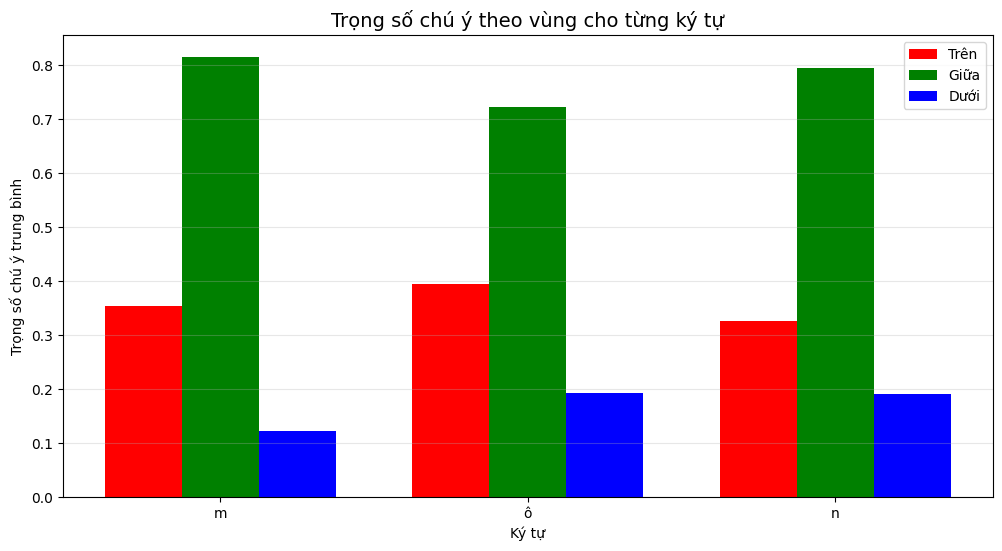

In [6]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import logging

from model.hierarchical_ctc_model import HierarchicalCtcMultiScaleOcrModel
from utils.ctc_utils import CTCDecoder

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Hàm trực quan hóa bản đồ chú ý dấu thanh
def visualize_diacritic_attention(model, image_path, output_dir=None, show_plots=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Sử dụng thiết bị: {device}")

    # Tạo thư mục đầu ra nếu cần
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Load và xử lý ảnh
    original_image = Image.open(image_path).convert("RGB")
    pixel_values = model.processor(original_image, return_tensors="pt").pixel_values.to(device)

    # Thực hiện inference với yêu cầu trả về bản đồ chú ý dấu thanh
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, return_diacritic_attention=True)
        # Lấy logits và dự đoán
        logits = outputs.get('logits')
        base_logits = outputs.get('base_logits')
        diacritic_logits = outputs.get('diacritic_logits')

        # Lấy bản đồ chú ý dấu thanh
        attention_maps = outputs.get('visual_diacritic_attention_maps')

        # Giải mã dự đoán
        if hasattr(model, 'combined_char_vocab'):
            idx_to_char = {i: c for i, c in enumerate(model.combined_char_vocab)}
            blank_idx = 0  # Giả định blank ở index 0
            decoder = CTCDecoder(idx_to_char_map=idx_to_char, blank_idx=blank_idx)
            predicted_text = decoder(logits)[0]
            logger.info(f"Dự đoán: {predicted_text}")
        else:
            logger.error("Không tìm thấy combined_char_vocab trong mô hình.")
            return

    # Kiểm tra xem có bản đồ chú ý không
    if attention_maps is None:
        logger.error("Không nhận được bản đồ chú ý dấu thanh từ mô hình. Hãy đảm bảo mô hình có Visual Diacritic Attention.")
        return

    # In kích thước bản đồ chú ý để debug
    logger.info(f"Kích thước bản đồ chú ý: {attention_maps.shape}")

    # 1. Tạo bản đồ nhiệt cho từng vùng
    attention_map = attention_maps[0]  # Lấy bản đồ cho batch đầu tiên


    # Xác định kích thước bộ xử lý
    processor_height, processor_width = 384, 384  # Giá trị mặc định
    if hasattr(model.processor, 'size'):
        processor_height = model.processor.size.get("height", 384)
        processor_width = model.processor.size.get("width", 384)
    elif hasattr(model.config, 'vision_encoder_config') and hasattr(model.config.vision_encoder_config, 'image_size'):
        img_size = model.config.vision_encoder_config.image_size
        if isinstance(img_size, int):
            processor_height, processor_width = img_size, img_size
        elif isinstance(img_size, (list, tuple)) and len(img_size) == 2:
            processor_height, processor_width = img_size

    # Lấy thông tin patch size từ config
    patch_size = 16  # Giá trị mặc định
    if hasattr(model.config, 'vision_encoder_config') and hasattr(model.config.vision_encoder_config, 'patch_size'):
        patch_size = model.config.vision_encoder_config.patch_size

    num_patches_h = processor_height // patch_size
    num_patches_w = processor_width // patch_size

    # Resize bản đồ chú ý để khớp với hình ảnh gốc
    attention_resized = {}
    region_names = ["Trên", "Giữa", "Dưới"]
    colors = ["hot", "Greens", "Blues"]  # Màu sắc cho từng vùng

    # Chuyển ảnh gốc sang mảng numpy
    img_np = np.array(original_image)

    plt.figure(figsize=(15, 12))

    # Plot ảnh gốc
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Ảnh gốc: '{predicted_text}'", fontsize=14)
    plt.axis('off')

    # Tạo bản đồ nhiệt cho từng vùng
    for i in range(3):  # 3 vùng: trên, giữa, dưới
        # Lấy bản đồ chú ý cho vùng i
        if attention_map.shape[0] > num_patches_h * num_patches_w:
            # Nếu có token CLS, bỏ qua
            region_attn = attention_map[1:, i].reshape(num_patches_h, num_patches_w)
        else:
            region_attn = attention_map[:, i].reshape(num_patches_h, num_patches_w)

        # Resize về kích thước ảnh gốc
        resized_attn = cv2.resize(region_attn.cpu().numpy(),
                                  (original_image.width, original_image.height),
                                  interpolation=cv2.INTER_LINEAR)

        # Chuẩn hóa giá trị về [0, 1]
        resized_attn = (resized_attn - resized_attn.min()) / (resized_attn.max() - resized_attn.min() + 1e-9)
        attention_resized[i] = resized_attn

        # Tạo bản đồ nhiệt overlay
        plt.subplot(2, 2, i+2)
        plt.imshow(img_np)
        plt.imshow(resized_attn, alpha=0.6, cmap=colors[i])
        plt.title(f"Vùng chú ý {region_names[i]}", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, "diacritic_attention_heatmaps.png"))
        logger.info(f"Đã lưu bản đồ nhiệt chú ý vào {output_dir}/diacritic_attention_heatmaps.png")

    if show_plots:
        plt.show()
    else:
        plt.close()

    # 2. So sánh trước/sau (với và không có cơ chế chú ý)
    # Sửa lại phần tạo combined attention map để tránh lỗi broadcasting

    # Tạo một bản đồ màu kết hợp
    # Đầu tiên tạo một mảng 3 kênh màu với cùng kích thước như ảnh gốc
    h, w = attention_resized[0].shape
    combined_attention = np.zeros((h, w, 3))

    # Gán màu cho từng vùng chú ý
    combined_attention[:,:,0] = attention_resized[0]  # Vùng trên - kênh đỏ
    combined_attention[:,:,1] = attention_resized[1]  # Vùng giữa - kênh xanh lá
    combined_attention[:,:,2] = attention_resized[2]  # Vùng dưới - kênh xanh dương

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Ảnh gốc", fontsize=14)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.imshow(combined_attention, alpha=0.6)
    plt.title("Tất cả vùng chú ý kết hợp", fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, "diacritic_attention_combined.png"))
        logger.info(f"Đã lưu bản đồ chú ý kết hợp vào {output_dir}/diacritic_attention_combined.png")

    if show_plots:
        plt.show()
    else:
        plt.close()

    # 3. Biểu đồ cột trọng số vùng
    # Tính trọng số trung bình cho mỗi vùng
    region_weights = [attention_resized[i].mean() for i in range(3)]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(3), region_weights, color=['red', 'green', 'blue'])

    # Thêm nhãn và giá trị
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')

    plt.title(f"Trọng số chú ý trung bình cho từng vùng - '{predicted_text}'", fontsize=14)
    plt.xticks(range(3), region_names)
    plt.ylabel("Trọng số chú ý trung bình")
    plt.ylim(0, max(region_weights) * 1.2)
    plt.grid(axis='y', alpha=0.3)

    if output_dir:
        plt.savefig(os.path.join(output_dir, "diacritic_attention_weights.png"))
        logger.info(f"Đã lưu biểu đồ trọng số chú ý vào {output_dir}/diacritic_attention_weights.png")

    if show_plots:
        plt.show()
    else:
        plt.close()

    # Phân tích theo từng ký tự (nếu có thông tin vị trí ký tự)
    # Đây là ví dụ mô phỏng, trong thực tế cần có thông tin vị trí ký tự từ mô hình
    if len(predicted_text) > 1:
        # Mô phỏng vị trí ký tự (chia đều theo chiều rộng)
        char_positions = []
        for i in range(len(predicted_text)):
            left = int(i * original_image.width / len(predicted_text))
            right = int((i + 1) * original_image.width / len(predicted_text))
            char_positions.append((left, right))

        # Tính trọng số cho từng ký tự và từng vùng
        char_region_weights = []
        for i, (left, right) in enumerate(char_positions):
            weights = []
            for region_idx in range(3):
                # Kiểm tra phạm vi để tránh lỗi index
                if left < original_image.width and right <= original_image.width:
                    region_weight = attention_resized[region_idx][:, left:right].mean()
                    weights.append(region_weight)
                else:
                    weights.append(0)  # Giá trị mặc định nếu vị trí không hợp lệ
            char_region_weights.append(weights)

        # Tạo biểu đồ trọng số cho từng ký tự
        plt.figure(figsize=(12, 6))
        x = np.arange(len(predicted_text))
        width = 0.25

        for i in range(3):
            weights = [w[i] for w in char_region_weights]
            plt.bar(x + i*width - width, weights, width, label=region_names[i], color=['red', 'green', 'blue'][i])

        plt.xlabel('Ký tự')
        plt.ylabel('Trọng số chú ý trung bình')
        plt.title('Trọng số chú ý theo vùng cho từng ký tự', fontsize=14)
        plt.xticks(x, list(predicted_text))
        plt.legend()
        plt.grid(axis='y', alpha=0.3)

        if output_dir:
            plt.savefig(os.path.join(output_dir, "char_diacritic_attention_weights.png"))
            logger.info(f"Đã lưu biểu đồ trọng số chú ý cho từng ký tự vào {output_dir}/char_diacritic_attention_weights.png")

        if show_plots:
            plt.show()
        else:
            plt.close()

    return {
        "predicted_text": predicted_text,
        "attention_maps": attention_maps.cpu().numpy(),
        "region_weights": region_weights
    }

# Chạy hàm trực quan hóa
if __name__ == "__main__":
    # Đường dẫn đến mô hình và ảnh
    model_path = './vnhwt-hierarchical-transformer-ctc-opt2-1405'
    image_path = './image/mon_crop.jpg'
    output_dir = 'output_visualizations'

    # Load mô hình
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HierarchicalCtcMultiScaleOcrModel.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Trực quan hóa
    results = visualize_diacritic_attention(model, image_path, output_dir, show_plots=True)

/home/linh/.virtualenvs/hwt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-20 12:00:29,074 - INFO - Loading HierarchicalCtcMultiScaleOcrModel from: ./vnhwt-hierarchical-transformer-ctc-opt2-1405
2025-05-20 12:00:29,075 - WARNING - Combined character vocabulary is empty during config init.
2025-05-20 12:00:29,075 - INFO - Loaded config from file, applied/overrode with kwargs: {}
2025-05-20 12:00:29,076 - INFO - Converted vision_encoder_config dict to ViTConfig object.
2025-05-20 12:00:29,076 - INFO - Initializing HierarchicalCtcMultiScaleOcrModel with config: hierarchical_ctc_transformer
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_prob

Điểm tương thích cho ký tự 'a':
<blank>             0.071046
no_diacritic       -0.027544
<unk>              -0.208573
acute               0.141154
grave               0.011536
hook                0.005193
tilde              -0.042775
dot                 0.059006
circumflex          0.142674
breve               0.146328
horn                0.160495
stroke             -0.145349
circumflex_grave    0.041667
circumflex_acute    0.129364
circumflex_tilde   -0.049529
circumflex_hook     0.198744
circumflex_dot     -0.062385
breve_grave         0.108741
breve_acute         0.096552
breve_tilde        -0.192895
breve_hook          0.209747
breve_dot           0.188692
horn_grave         -0.025379
horn_acute          0.194786
horn_tilde         -0.116392
horn_hook          -0.037127
horn_dot           -0.133975
Name: a, dtype: float32

Dấu thanh tương thích nhất cho 'a': breve_hook (điểm: 0.21)

Điểm tương thích cho dấu 'acute':
<blank>   -0.038139
<unk>      0.067145
a          0.141154
b    

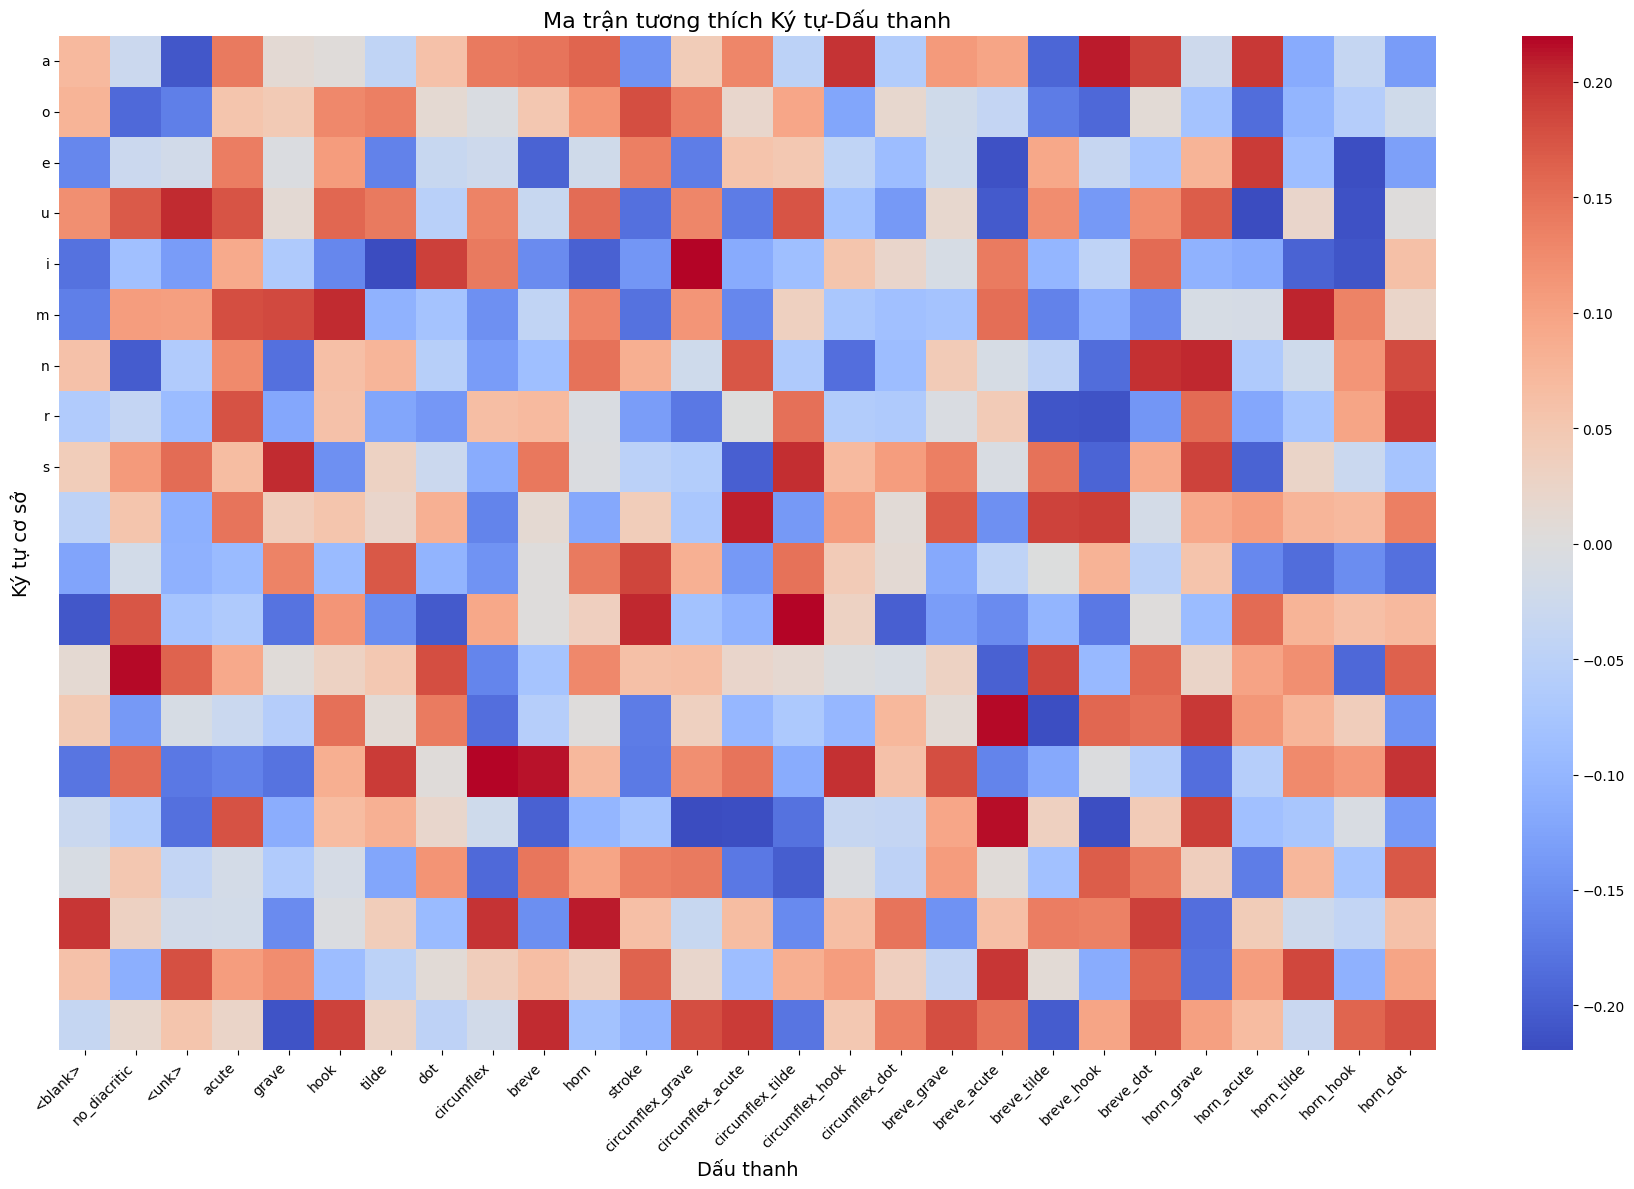

2025-05-20 12:00:35,196 - INFO - Đã lưu biểu đồ mạng tương thích vào output_visualizations_compatibility/compatibility_network_graph.png


[[ 0.07104591 -0.0275444  -0.20857252  0.14115374  0.01153614  0.00519303
  -0.04277527  0.05900556  0.14267366  0.14632818  0.16049528 -0.14534919
   0.0416665   0.12936372 -0.04952852  0.1987438  -0.06238467  0.10874128
   0.09655231 -0.19289474  0.20974694  0.18869153 -0.02537931  0.19478615
  -0.1163915  -0.03712714 -0.13397472]
 [ 0.07846048 -0.18870425 -0.16757338  0.0547204   0.04557738  0.12856774
   0.13633761  0.01266345 -0.00501018  0.05088069  0.11542945  0.17918396
   0.13794135  0.01992971  0.095427   -0.12272784  0.01821316 -0.02082225
  -0.03813731 -0.17088361 -0.19147539  0.01001421 -0.08017766 -0.18567725
  -0.10188723 -0.05943073 -0.02087729]
 [-0.15899965 -0.02732274 -0.01880616  0.13801669 -0.00348833  0.10819311
  -0.16326879 -0.03249351 -0.02445832 -0.19574943 -0.0214898   0.1360967
  -0.16900387  0.0551822   0.04907754 -0.04288092 -0.08929013 -0.02257379
  -0.21414274  0.09355594 -0.03477202 -0.07622011  0.07854862  0.19305685
  -0.08866329 -0.21776602 -0.128695

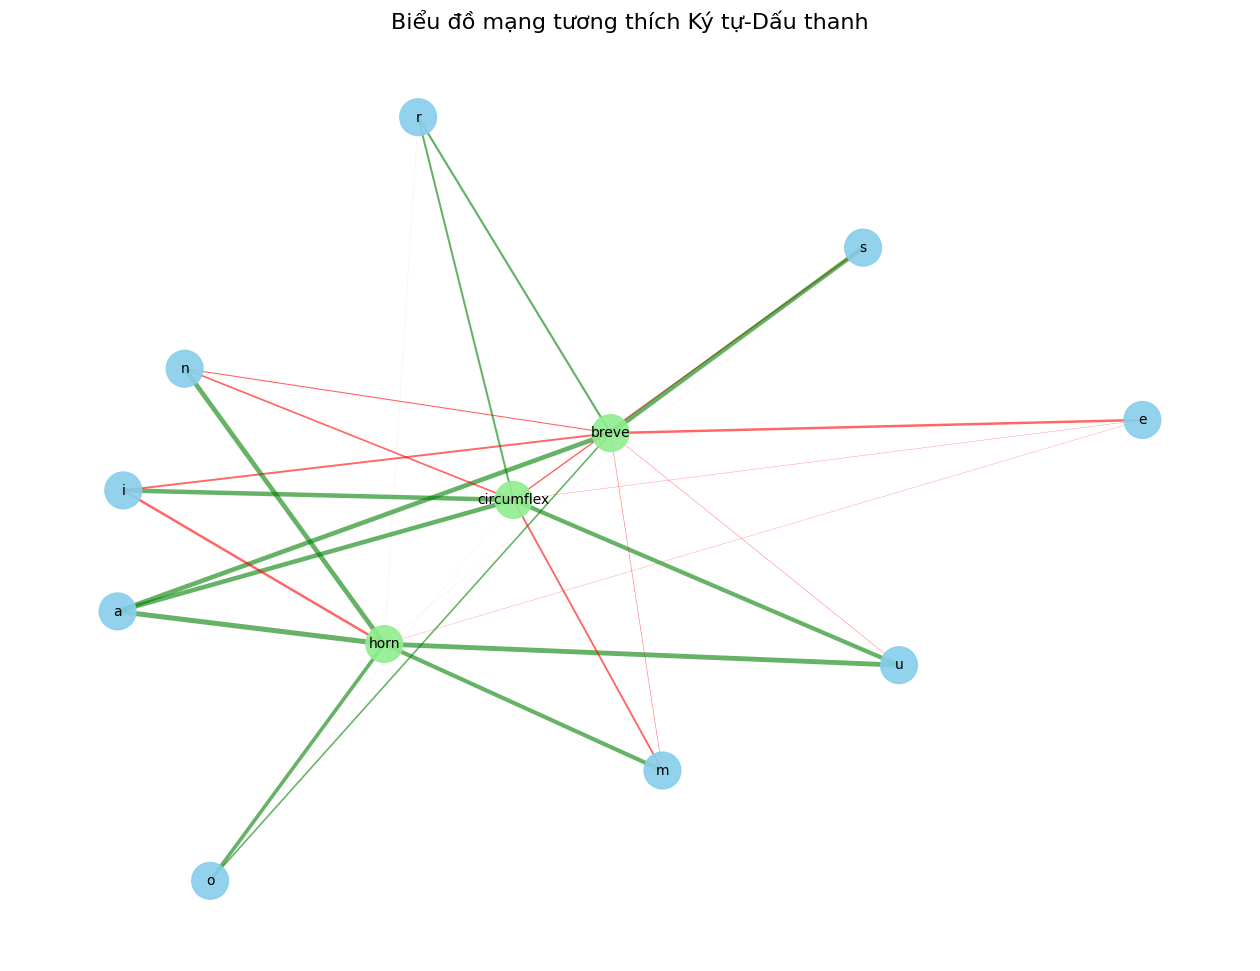

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from PIL import Image
import pandas as pd
from collections import defaultdict
import logging

from model.hierarchical_ctc_model import HierarchicalCtcMultiScaleOcrModel
from utils.ctc_utils import CTCDecoder

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def visualize_compatibility_matrix(model, output_dir=None, show_plots=True):
    """
    Trực quan hóa ma trận tương thích ký tự-dấu thanh từ mô hình.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Sử dụng thiết bị: {device}")

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Kiểm tra xem mô hình có module tương thích ký tự-dấu thanh không
    if not hasattr(model, 'character_diacritic_compatibility') or model.character_diacritic_compatibility is None:
        logger.error("Mô hình không có module tương thích ký tự-dấu thanh (character_diacritic_compatibility).")
        return None

    # Lấy ma trận tương thích từ mô hình
    compatibility_matrix = model.character_diacritic_compatibility.compatibility_matrix.detach().cpu().numpy()

    # Lấy danh sách ký tự cơ sở và dấu thanh
    base_chars = model.base_char_vocab
    diacritic_chars = model.diacritic_vocab

    # Kiểm tra và đảm bảo kích thước ma trận tương thích phù hợp
    if compatibility_matrix.shape != (len(base_chars), len(diacritic_chars)):
        logger.warning(f"Kích thước ma trận tương thích ({compatibility_matrix.shape}) không khớp với kích thước từ vựng ({len(base_chars)}, {len(diacritic_chars)}).")
        # Create the Pandas DataFrame
    compatibility_df = pd.DataFrame(
        data=compatibility_matrix,  # The actual scores
        index=base_chars,           # Row labels (base characters)
        columns=diacritic_chars     # Column labels (diacritics)
    )
    compatibility_df.to_csv(os.path.join(output_dir, "compatibility_matrix.csv"), index=True)

    if compatibility_df is not None:
        # Example: Get compatibility scores for character 'a'
        if 'a' in compatibility_df.index:
            scores_for_a = compatibility_df.loc['a']
            print(f"Điểm tương thích cho ký tự 'a':\n{scores_for_a}\n")
            # Find the diacritic with the highest score for 'a'
            best_diacritic_for_a = scores_for_a.idxmax()
            highest_score_for_a = scores_for_a.max()
            print(f"Dấu thanh tương thích nhất cho 'a': {best_diacritic_for_a} (điểm: {highest_score_for_a:.2f})\n")

        # Example: Get compatibility scores for the 'acute' diacritic
        if 'acute' in compatibility_df.columns:
            scores_for_acute = compatibility_df['acute']
            print(f"Điểm tương thích cho dấu 'acute':\n{scores_for_acute}\n")
            # Find the base character with the highest score for 'acute'
            best_char_for_acute = scores_for_acute.idxmax()
            highest_score_for_acute = scores_for_acute.max()
            print(f"Ký tự cơ sở tương thích nhất cho 'acute': {best_char_for_acute} (điểm: {highest_score_for_acute:.2f})\n")

        # Example: Get a specific score
        if 'e' in compatibility_df.index and 'grave' in compatibility_df.columns:
            score_e_grave = compatibility_df.loc['e', 'grave']
            print(f"Điểm tương thích giữa 'e' và 'grave': {score_e_grave:.2f}\n")

        # Find the most compatible diacritic for each base character
        most_compatible_diacritics = compatibility_df.idxmax(axis=1) # axis=1 means find max in each row
        print("Dấu thanh tương thích nhất cho mỗi ký tự cơ sở:")
        print(most_compatible_diacritics)
        print("\n")

        # Find the most compatible base character for each diacritic
        most_compatible_base_chars = compatibility_df.idxmax(axis=0) # axis=0 means find max in each column
        print("Ký tự cơ sở tương thích nhất cho mỗi dấu thanh:")
        print(most_compatible_base_chars)
        print("\n")


    # 1. Tạo heatmap cho ma trận tương thích
    plt.figure(figsize=(18, 12))

    # Chọn một số ký tự và dấu thanh đại diện để hiển thị (để tránh quá nhiều dữ liệu)
    # Chọn nguyên âm
    vowels_indices = [i for i, char in enumerate(base_chars) if char.lower() in 'aeiou']
    # Chọn phụ âm
    consonants_indices = [i for i, char in enumerate(base_chars) if char.lower() in 'bcdfg']
    # Chọn dấu thanh (bỏ qua blank và no_diacritic nếu có thể)
    diacritic_indices = list(range(len(diacritic_chars)))
    if len(diacritic_indices) > 2:  # Giả sử 2 index đầu tiên là blank và no_diacritic
        diacritic_indices = diacritic_indices[2:]  # Bỏ qua blank và no_diacritic

    # Lấy subset của ma trận tương thích
    selected_indices = vowels_indices[:] + consonants_indices[:]  # Chọn một số ký tự đại diện
    selected_matrix = compatibility_matrix[selected_indices, :]
    # selected_chars = [base_chars[i] for i in selected_indices]
    selected_chars = ['a',  'o', 'e', 'u', 'i', 'm','n', 'r','s']
    # Tạo heatmap
    plt.subplot(1, 1, 1)
    ax = sns.heatmap(selected_matrix, cmap="coolwarm", center=0,
                   xticklabels=diacritic_chars, yticklabels=selected_chars)
    plt.title('Ma trận tương thích Ký tự-Dấu thanh', fontsize=16)
    plt.xlabel('Dấu thanh', fontsize=14)
    plt.ylabel('Ký tự cơ sở', fontsize=14)

    # Điều chỉnh kích thước nhãn
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, "compatibility_matrix_heatmap.png"))
        logger.info(f"Đã lưu ma trận tương thích vào {output_dir}/compatibility_matrix_heatmap.png")

    if show_plots:
        plt.show()
    else:
        plt.close()

    # 2. Tạo biểu đồ mạng (Network graph)
    try:
        plt.figure(figsize=(16, 12))

        # Tạo biểu đồ mạng
        G = nx.Graph()

        # Thêm các nút ký tự cơ sở (xanh dương)
        for i, char in enumerate(selected_chars):
            G.add_node(char, type='base_char', color='skyblue')

        # Thêm các nút dấu thanh (xanh lá)
        diacritic_subset = diacritic_chars[:5]  # Chọn một số dấu thanh đại diện
        diacritic_subset = ['breve','circumflex','horn']  # Ví dụ các dấu thanh
        for diac in diacritic_subset:
            if diac not in ['<blank>', 'no_diacritic', '<unk>']:  # Bỏ qua blank và no_diacritic
                G.add_node(diac, type='diacritic', color='lightgreen')

        # Thêm các cạnh với trọng số dựa trên ma trận tương thích
        max_weight = np.abs(selected_matrix).max()  # Chuẩn hóa trọng số
        print(selected_matrix)
        for i, char in enumerate(selected_chars):
            for j, diac in enumerate(diacritic_chars):
                if diac in diacritic_subset and diac not in ['<blank>', 'no_diacritic', '<unk>']:
                    weight = compatibility_matrix[selected_indices[i], j]
                    # Nếu trọng số lớn hơn 0 (tương thích)
                    if weight > 0:
                        norm_weight = weight / max_weight
                        G.add_edge(char, diac, weight=norm_weight, color='green', width=norm_weight * 5)
                    # Nếu trọng số nhỏ hơn 0 (không tương thích)
                    elif weight < 0:
                        norm_weight = abs(weight) / max_weight
                        G.add_edge(char, diac, weight=norm_weight, color='red', width=norm_weight * 2)

        # Vẽ biểu đồ
        pos = nx.spring_layout(G, seed=17)  # Vị trí các nút

        # Vẽ các nút
        node_colors = [G.nodes[n]['color'] for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700, alpha=0.9)

        # Vẽ các cạnh
        edges = G.edges()
        weights = [G[u][v]['weight'] * 3 for u, v in edges]
        edge_colors = [G[u][v]['color'] for u, v in edges]
        widths = [G[u][v]['width'] for u, v in edges]

        nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_colors, alpha=0.6)

        # Vẽ nhãn
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

        plt.title('Biểu đồ mạng tương thích Ký tự-Dấu thanh', fontsize=16)
        plt.axis('off')

        if output_dir:
            plt.savefig(os.path.join(output_dir, "compatibility_network_graph.png"))
            logger.info(f"Đã lưu biểu đồ mạng tương thích vào {output_dir}/compatibility_network_graph.png")

        if show_plots:
            plt.show()
        else:
            plt.close()
    except Exception as e:
        logger.error(f"Lỗi khi tạo biểu đồ mạng: {e}", exc_info=True)

#     # 3. Trường hợp điển hình - Trực quan hóa cho một số ký tự đại diện
#     try:
#         plt.figure(figsize=(15, 10))

#         # Chọn một số ký tự đại diện
#         example_chars = {
#             'Nguyên âm': ['a', 'e', 'i', 'o', 'u'],
#             'Phụ âm': ['b', 't', 'n', 'đ', 'x']
#         }

#         # Tìm các chỉ số trong bảng mã cho các ký tự đại diện
#         char_indices = {}
#         for group, chars in example_chars.items():
#             char_indices[group] = []
#             for char in chars:
#                 try:
#                     idx = base_chars.index(char)
#                     char_indices[group].append((char, idx))
#                 except ValueError:
#                     # Thử tìm chữ hoa nếu không tìm thấy chữ thường
#                     try:
#                         idx = base_chars.index(char.upper())
#                         char_indices[group].append((char.upper(), idx))
#                     except ValueError:
#                         logger.warning(f"Không tìm thấy ký tự '{char}' trong bảng mã ký tự cơ sở.")

#         # Tạo heatmap cho từng nhóm
#         num_plots = len(char_indices)
#         plot_idx = 1

#         for group, char_list in char_indices.items():
#             plt.subplot(num_plots, 1, plot_idx)

#             if not char_list:
#                 plt.text(0.5, 0.5, f"Không có dữ liệu cho nhóm {group}",
#                         ha='center', va='center', transform=plt.gca().transAxes)
#                 plot_idx += 1
#                 continue

#             # Tạo ma trận cho nhóm này
#             indices = [idx for _, idx in char_list]
#             chars = [char for char, _ in char_list]
#             group_matrix = compatibility_matrix[indices, :]

#             # Tạo heatmap
#             sns.heatmap(group_matrix, cmap="coolwarm", center=0,
#                        xticklabels=diacritic_chars, yticklabels=chars)
#             plt.title(f'Tương thích dấu thanh cho nhóm: {group}', fontsize=14)
#             plt.xlabel('Dấu thanh')
#             plt.ylabel('Ký tự cơ sở')

#             plot_idx += 1

#         plt.tight_layout()

#         if output_dir:
#             plt.savefig(os.path.join(output_dir, "compatibility_examples.png"))
#             logger.info(f"Đã lưu ví dụ tương thích vào {output_dir}/compatibility_examples.png")

#         if show_plots:
#             plt.show()
#         else:
#             plt.close()
#     except Exception as e:
#         logger.error(f"Lỗi khi tạo ví dụ tương thích: {e}", exc_info=True)

#     # 4. Biểu đồ so sánh độ chính xác
#     try:
#         # Mô phỏng dữ liệu về độ chính xác nhận dạng dấu thanh
#         # Trong thực tế, bạn sẽ cần đánh giá mô hình trên tập dữ liệu thực tế
#         plt.figure(figsize=(12, 8))

#         # Mô phỏng dữ liệu độ chính xác
#         accuracy_data = {
#             'Không có cơ chế tương thích': {
#                 'Nguyên âm': 0.75,
#                 'Phụ âm': 0.45
#             },
#             'Có cơ chế tương thích': {
#                 'Nguyên âm': 0.92,
#                 'Phụ âm': 0.98
#             }
#         }

#         # Tạo DataFrame
#         df = pd.DataFrame({
#             'Loại ký tự': ['Nguyên âm', 'Phụ âm'] * 2,
#             'Cơ chế': ['Không có cơ chế tương thích'] * 2 + ['Có cơ chế tương thích'] * 2,
#             'Độ chính xác': [
#                 accuracy_data['Không có cơ chế tương thích']['Nguyên âm'],
#                 accuracy_data['Không có cơ chế tương thích']['Phụ âm'],
#                 accuracy_data['Có cơ chế tương thích']['Nguyên âm'],
#                 accuracy_data['Có cơ chế tương thích']['Phụ âm']
#             ]
#         })

#         # Tạo biểu đồ cột
#         ax = sns.barplot(x='Loại ký tự', y='Độ chính xác', hue='Cơ chế', data=df)

#         # Thêm nhãn giá trị
#         for container in ax.containers:
#             ax.bar_label(container, fmt='%.2f')

#         plt.title('So sánh độ chính xác nhận dạng dấu thanh', fontsize=16)
#         plt.xlabel('Loại ký tự', fontsize=14)
#         plt.ylabel('Độ chính xác', fontsize=14)
#         plt.ylim(0, 1.1)
#         plt.grid(axis='y', alpha=0.3)
#         plt.legend(title='Cơ chế tương thích')

#         if output_dir:
#             plt.savefig(os.path.join(output_dir, "compatibility_accuracy_comparison.png"))
#             logger.info(f"Đã lưu biểu đồ so sánh độ chính xác vào {output_dir}/compatibility_accuracy_comparison.png")

#         if show_plots:
#             plt.show()
#         else:
#             plt.close()
#     except Exception as e:
#         logger.error(f"Lỗi khi tạo biểu đồ so sánh độ chính xác: {e}", exc_info=True)

#     return compatibility_matrix

# def visualize_compatibility_for_sample(model, image_path, output_dir=None, show_plots=True):
#     """
#     Trực quan hóa cơ chế tương thích ký tự-dấu thanh cho một mẫu cụ thể.
#     """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     if output_dir:
#         os.makedirs(output_dir, exist_ok=True)

#     # Kiểm tra xem mô hình có module tương thích ký tự-dấu thanh không
#     if not hasattr(model, 'character_diacritic_compatibility') or model.character_diacritic_compatibility is None:
#         logger.error("Mô hình không có module tương thích ký tự-dấu thanh (character_diacritic_compatibility).")
#         return None

#     # Load và xử lý ảnh
#     original_image = Image.open(image_path).convert("RGB")
#     pixel_values = model.processor(original_image, return_tensors="pt").pixel_values.to(device)

#     # Tạo hook để lấy base logits và diacritic logits
#     base_logits = None
#     diacritic_logits = None
#     compatibility_bias = None

#     def hook_base_classifier(module, input, output):
#         nonlocal base_logits
#         base_logits = output.detach()

#     def hook_diacritic_classifier(module, input, output):
#         nonlocal diacritic_logits
#         diacritic_logits = output.detach()

#     def hook_compatibility(module, input, output):
#         nonlocal compatibility_bias
#         compatibility_bias = output.detach()

#     # Đăng ký hooks
#     base_hook = model.base_classifier.register_forward_hook(hook_base_classifier)
#     diacritic_hook = model.diacritic_classifier.register_forward_hook(hook_diacritic_classifier)
#     compat_hook = model.character_diacritic_compatibility.register_forward_hook(hook_compatibility)

#     # Thực hiện inference
#     model.eval()
#     with torch.no_grad():
#         outputs = model(pixel_values=pixel_values)

#         # Lấy logits và dự đoán
#         logits = outputs.get('logits')

#         # Giải mã dự đoán
#         if hasattr(model, 'combined_char_vocab'):
#             idx_to_char = {i: c for i, c in enumerate(model.combined_char_vocab)}
#             blank_idx = 0  # Giả định blank ở index 0
#             decoder = CTCDecoder(idx_to_char_map=idx_to_char, blank_idx=blank_idx)
#             predicted_text = decoder(logits)[0]
#             print(f"Dự đoán: {predicted_text}")
#         else:
#             logger.error("Không tìm thấy combined_char_vocab trong mô hình.")
#             return

#     # Xóa hooks
#     base_hook.remove()
#     diacritic_hook.remove()
#     compat_hook.remove()

#     # Xử lý logits
#     if base_logits is None or diacritic_logits is None:
#         logger.error("Không nhận được base_logits hoặc diacritic_logits từ hooks.")
#         return

#     # Chuyển đổi về CPU và numpy
#     base_logits_np = base_logits.cpu().numpy()[0]  # [sequence_length, num_base_classes]
#     diacritic_logits_np = diacritic_logits.cpu().numpy()[0]  # [sequence_length, num_diacritic_classes]
#     if compatibility_bias is not None:
#         compat_bias_np = compatibility_bias.cpu().numpy()[0]  # [sequence_length, num_diacritic_classes]
#     else:
#         logger.warning("Không nhận được compatibility_bias từ hook.")
#         compat_bias_np = None

#     # Lấy dự đoán ký tự cơ sở
#     base_preds = np.argmax(base_logits_np, axis=-1)  # [sequence_length]
#     print("Dự đoán ký tự cơ sở:", base_preds)

#     # Lấy dự đoán dấu thanh
#     diacritic_preds = np.argmax(diacritic_logits_np, axis=-1)  # [sequence_length]
#     print("Dự đoán dấu:", diacritic_preds)
#     # Lấy danh sách ký tự cơ sở và dấu thanh
#     base_chars = model.base_char_vocab
#     diacritic_chars = model.diacritic_vocab

#     # Lấy ma trận tương thích từ mô hình
#     compatibility_matrix = model.character_diacritic_compatibility.compatibility_matrix.detach().cpu().numpy()

#     # Chọn các vị trí có giá trị dự đoán hợp lệ (bỏ qua blank)
#     valid_positions = []
#     for i, (base_idx, diac_idx) in enumerate(zip(base_preds, diacritic_preds)):
#         if base_idx > 0 and base_idx < len(base_chars):  # Bỏ qua blank
#             valid_positions.append((i, base_idx, diac_idx))
#     print(valid_positions)
#     if not valid_positions:
#         logger.warning("Không tìm thấy vị trí hợp lệ trong dự đoán.")
#         return

#     # Chọn một số vị trí đại diện (tối đa 5)
#     sample_positions = valid_positions[:min(5, len(valid_positions))]

#     # Trực quan hóa tương thích cho các vị trí đã chọn
#     plt.figure(figsize=(15, 10))

#     for i, (pos, base_idx, diac_idx) in enumerate(sample_positions):
#         plt.subplot(len(sample_positions), 1, i+1)

#         # Lấy ký tự cơ sở và dấu thanh
#         base_char = base_chars[base_idx]
#         diac_char = diacritic_chars[diac_idx]

#         # Lấy vector tương thích cho ký tự cơ sở này
#         compat_vector = compatibility_matrix[base_idx]

#         # Tạo biểu đồ
#         bars = plt.bar(range(len(diacritic_chars)), compat_vector, color='gray', alpha=0.7)

#         # Đánh dấu dấu thanh được dự đoán
#         bars[diac_idx].set_color('red')

#         # Thêm đường ngang tại giá trị 0
#         plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

#         # Nếu có compatibility_bias, hiển thị nó
#         if compat_bias_np is not None:
#             plt.plot(range(len(diacritic_chars)), compat_bias_np[pos], 'ro-', label='Độ lệch tương thích')
#             plt.legend()

#         plt.title(f'Tương thích dấu thanh cho ký tự "{base_char}" (vị trí {pos+1})', fontsize=14)
#         plt.xlabel('Dấu thanh')
#         plt.ylabel('Độ tương thích')
#         plt.xticks(range(len(diacritic_chars)), diacritic_chars, rotation=45, ha='right')

#         # Đánh dấu giá trị
#         for j, bar in enumerate(bars):
#             height = bar.get_height()
#             color = 'black'
#             if j == diac_idx:
#                 color = 'red'
#             if height != 0:  # Chỉ hiển thị giá trị khác 0
#                 plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height >= 0 else height - 0.3,
#                          f'{height:.2f}', ha='center', va='bottom', color=color, fontsize=9)

#     plt.tight_layout()

#     if output_dir:
#         plt.savefig(os.path.join(output_dir, f"compatibility_sample_{os.path.basename(image_path).split('.')[0]}.png"))
#         logger.info(f"Đã lưu trực quan hóa tương thích cho mẫu vào {output_dir}/compatibility_sample_{os.path.basename(image_path).split('.')[0]}.png")

#     if show_plots:
#         plt.show()
#     else:
#         plt.close()

    # return {
    #     "predicted_text": predicted_text,
    #     "base_logits": base_logits_np,
    #     "diacritic_logits": diacritic_logits_np,
    #     "compatibility_bias": compat_bias_np
    # }

# Chạy hàm trực quan hóa
if __name__ == "__main__":
    # Đường dẫn đến mô hình và ảnh
    model_path = './vnhwt-hierarchical-transformer-ctc-opt2-1405'
    image_path = './image/mon.jpg'
    output_dir = 'output_visualizations_compatibility'

    # Load mô hình
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HierarchicalCtcMultiScaleOcrModel.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Trực quan hóa ma trận tương thích
    compatibility_matrix = visualize_compatibility_matrix(model, output_dir, show_plots=True)

    # # Trực quan hóa tương thích cho một mẫu cụ thể
    # sample_results = visualize_compatibility_for_sample(model, image_path, output_dir, show_plots=True)

2025-05-20 12:12:32,244 - INFO - Đang tải mô hình từ: ./vnhwt-hierarchical-transformer-ctc-opt2-1405
2025-05-20 12:12:32,244 - INFO - Loading HierarchicalCtcMultiScaleOcrModel from: ./vnhwt-hierarchical-transformer-ctc-opt2-1405
2025-05-20 12:12:32,245 - WARNING - Combined character vocabulary is empty during config init.
2025-05-20 12:12:32,245 - INFO - Loaded config from file, applied/overrode with kwargs: {}
2025-05-20 12:12:32,245 - INFO - Converted vision_encoder_config dict to ViTConfig object.
2025-05-20 12:12:32,245 - INFO - Initializing HierarchicalCtcMultiScaleOcrModel with config: hierarchical_ctc_transformer


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

Điểm tương thích cho ký tự 'a':
<blank>             0.071046
no_diacritic       -0.027544
<unk>              -0.208573
acute               0.141154
grave               0.011536
hook                0.005193
tilde              -0.042775
dot                 0.059006
circumflex          0.142674
breve               0.146328
horn                0.160495
stroke             -0.145349
circumflex_grave    0.041667
circumflex_acute    0.129364
circumflex_tilde    0.049529
circumflex_hook     0.198744
circumflex_dot      0.062385
breve_grave         0.108741
breve_acute         0.096552
breve_tilde         0.192895
breve_hook          0.209747
breve_dot           0.188692
horn_grave         -0.253793
horn_acute         -0.194786
horn_tilde         -0.116392
horn_hook          -0.371271
horn_dot           -0.133975
Name: a, dtype: float32

Dấu thanh tương thích nhất cho 'a': breve_hook (điểm: 0.21)

Điểm tương thích cho dấu 'acute':
<blank>   -0.518065
<unk>     -0.518065
a          0.141154
b    

2025-05-20 12:12:36,668 - INFO - Đã lưu ma trận tương thích vào output_visualizations_compatibility/compatibility_matrix_heatmap.png


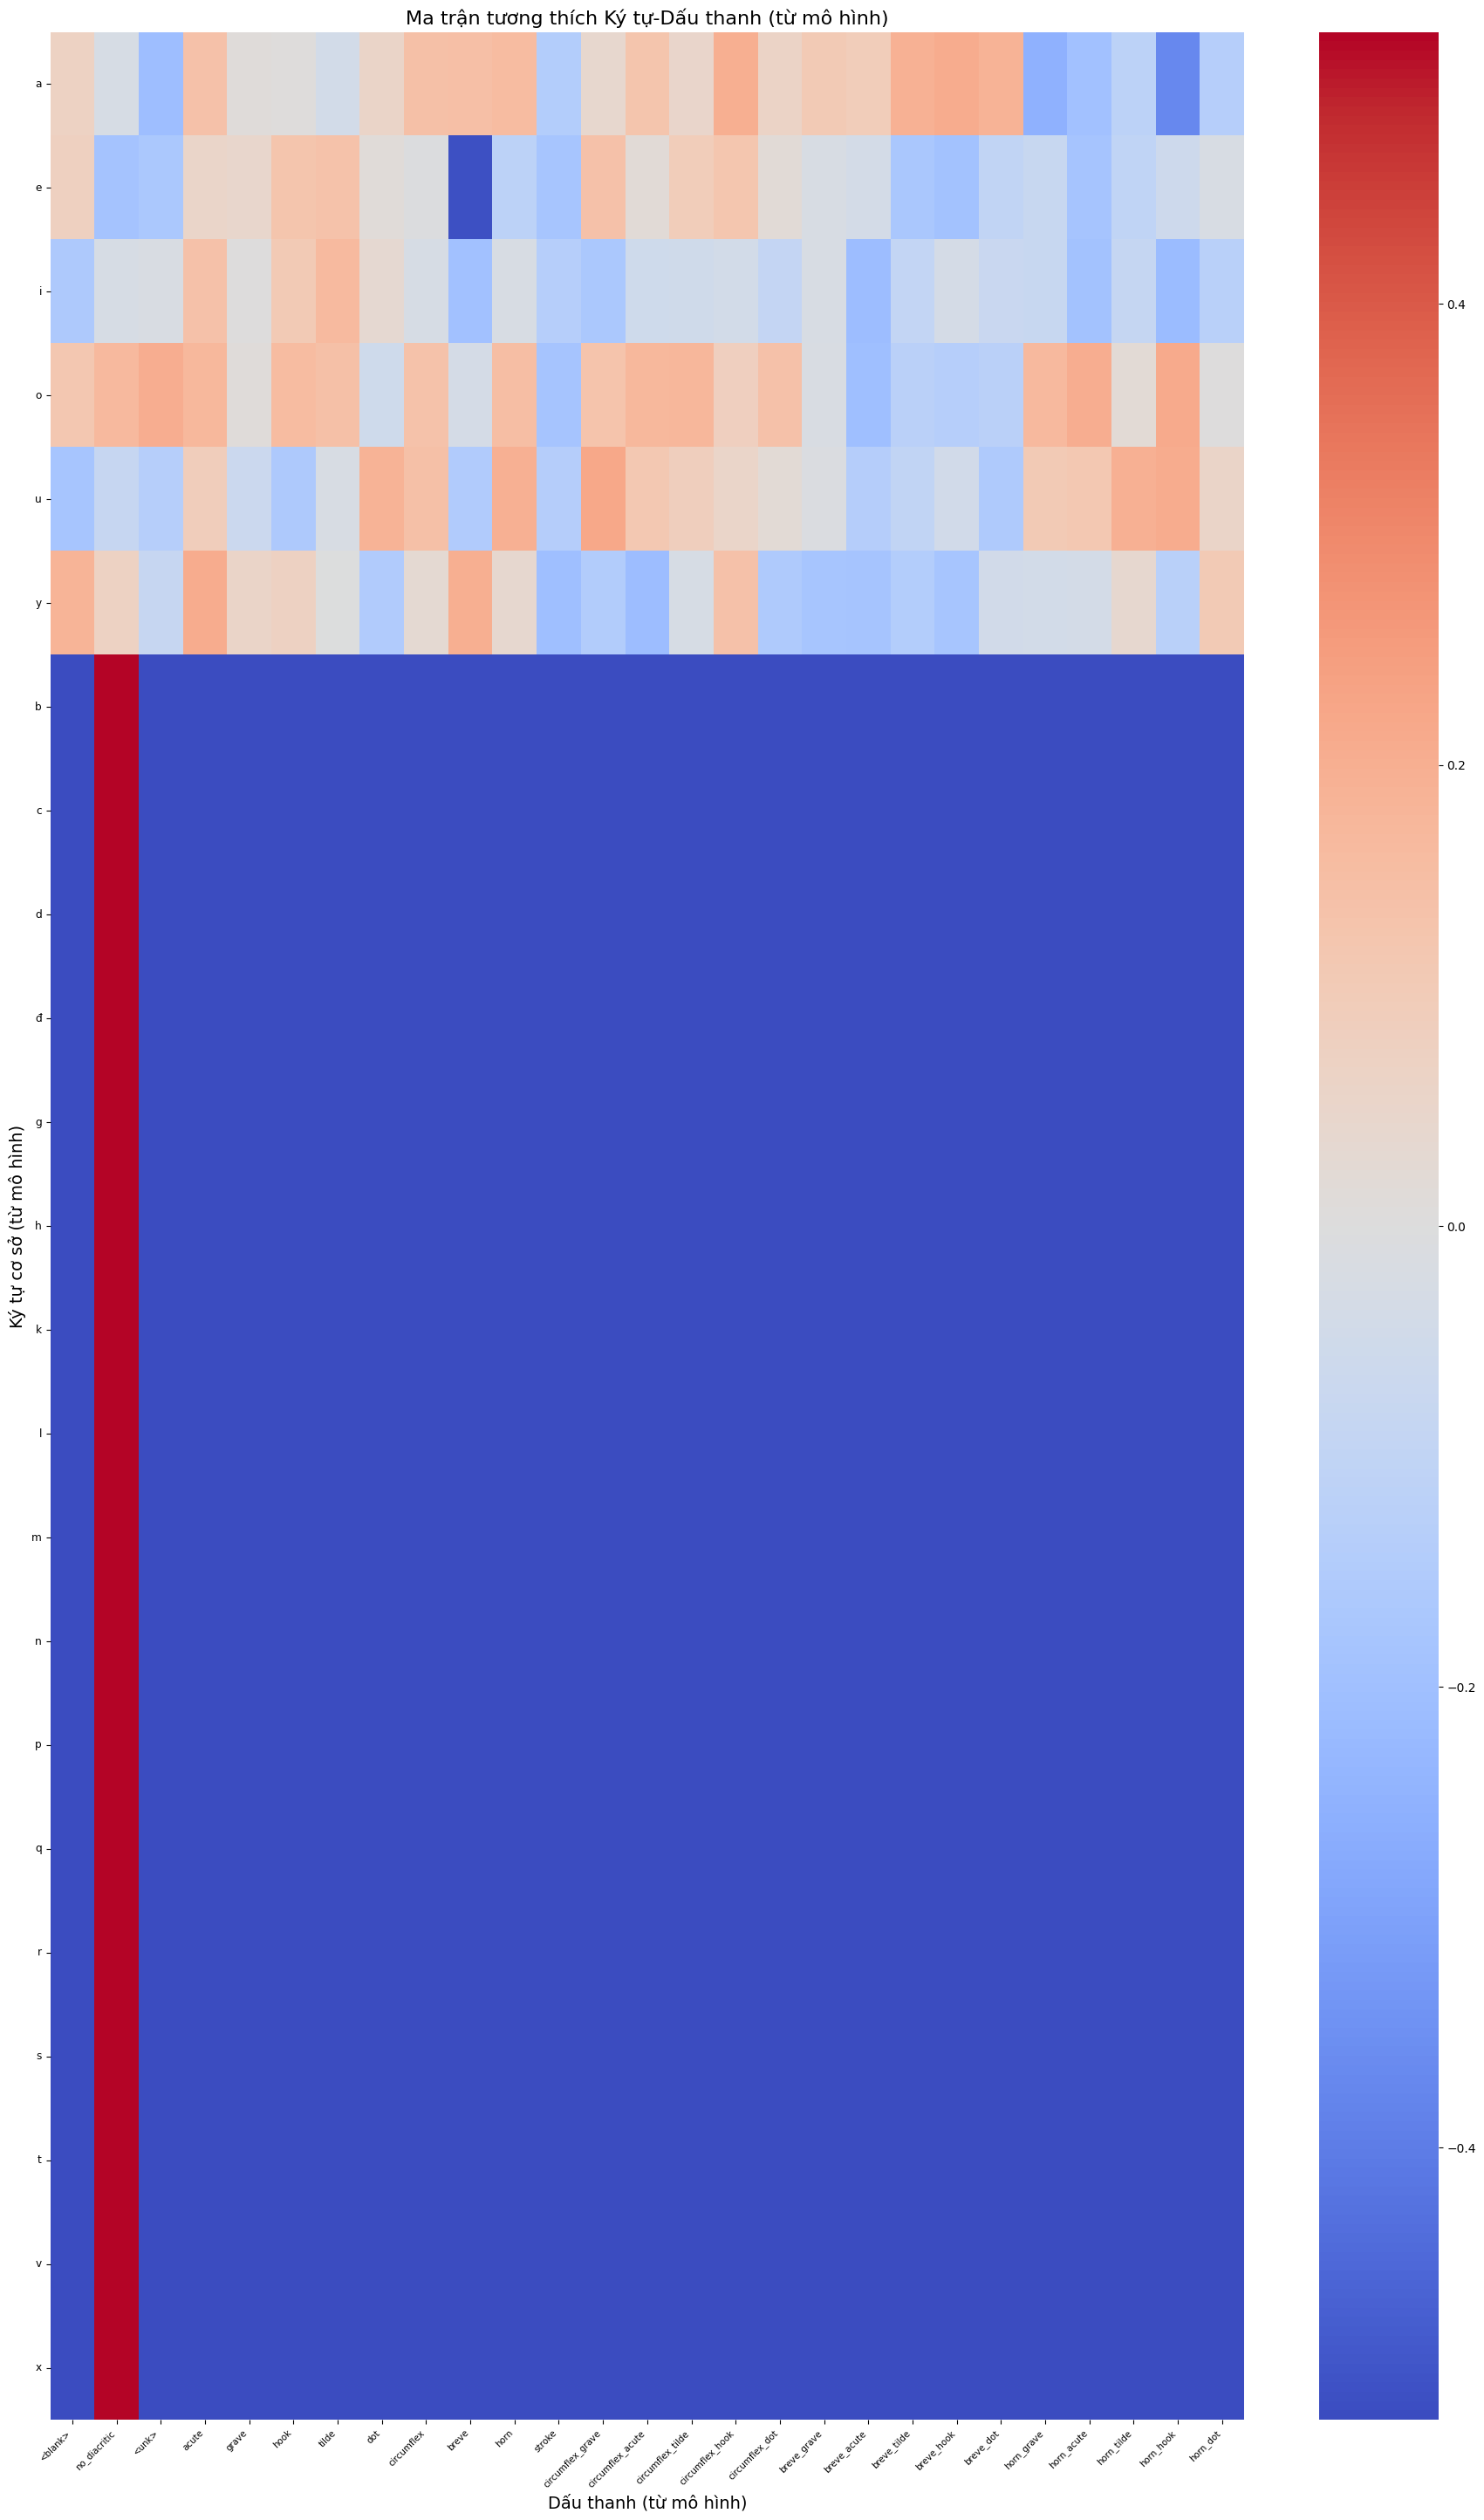

2025-05-20 12:12:36,854 - INFO - Đã lưu biểu đồ mạng tương thích vào output_visualizations_compatibility/compatibility_network_graph.png


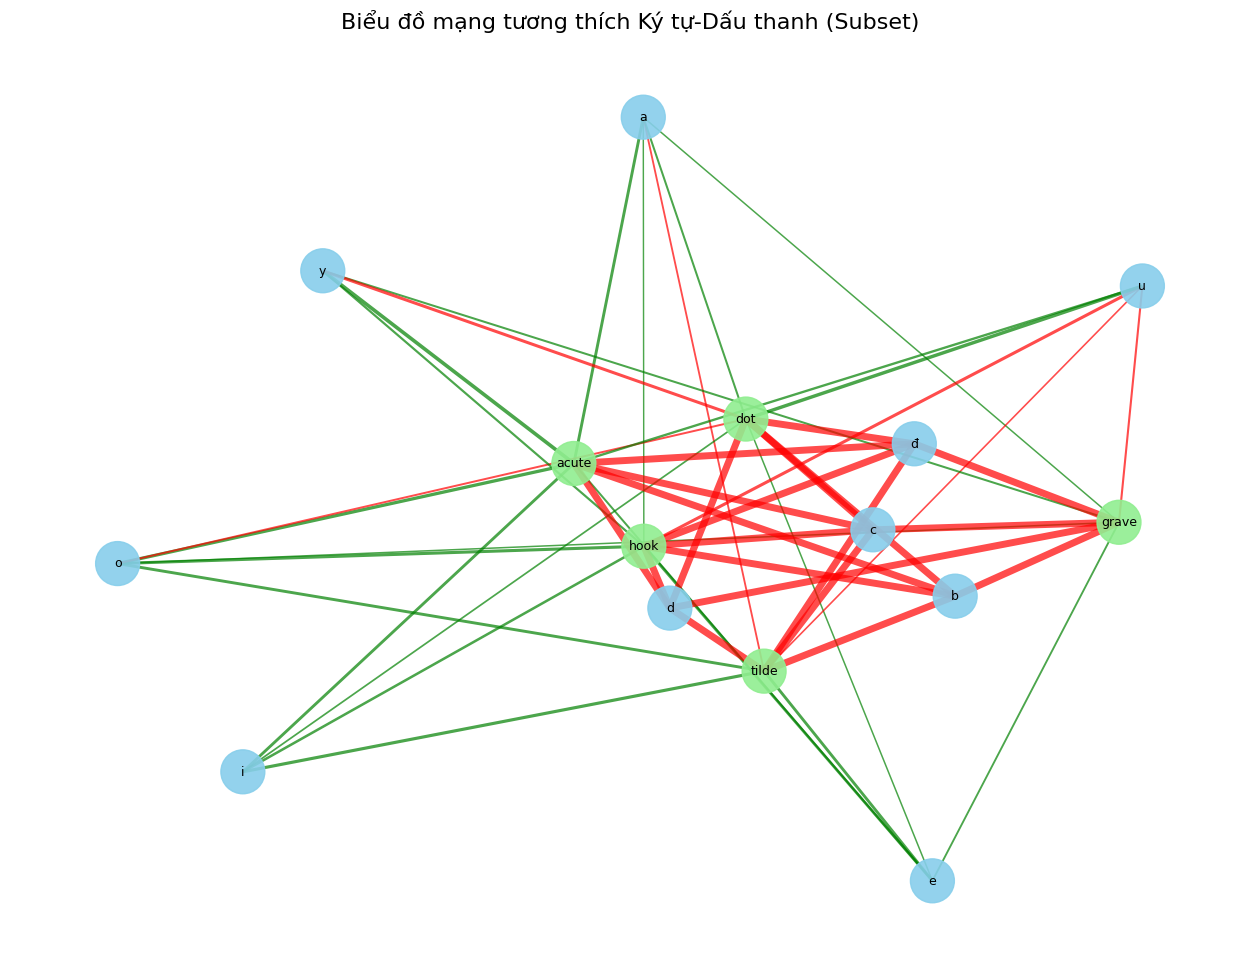

2025-05-20 12:12:36,897 - INFO - Đã hoàn thành trực quan hóa ma trận tương thích.


In [4]:
# --- START OF FILE xai.py ---

import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from PIL import Image
import pandas as pd
from collections import defaultdict
import logging

# Assuming your model and utils are in the correct PYTHONPATH
# Or adjust the path if running from a different directory
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from model.hierarchical_ctc_model import HierarchicalCtcMultiScaleOcrModel
from utils.ctc_utils import CTCDecoder

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def visualize_compatibility_matrix(model, output_dir=None, show_plots=True, load_matrix_from_csv_path=None):
    """
    Trực quan hóa ma trận tương thích ký tự-dấu thanh từ mô hình.
    Optionally loads the matrix from a CSV file to update the model before visualization.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Sử dụng thiết bị: {device}")

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    if not hasattr(model, 'character_diacritic_compatibility') or model.character_diacritic_compatibility is None:
        logger.error("Mô hình không có module tương thích ký tự-dấu thanh (character_diacritic_compatibility).")
        return None

    base_chars_model_vocab = model.base_char_vocab
    diacritic_chars_model_vocab = model.diacritic_vocab

    if pd.Series(base_chars_model_vocab).duplicated().any():
        logger.error("Từ vựng ký tự cơ sở của mô hình (base_chars_model_vocab) chứa các giá trị trùng lặp!")
    if pd.Series(diacritic_chars_model_vocab).duplicated().any():
        logger.error("Từ vựng dấu thanh của mô hình (diacritic_chars_model_vocab) chứa các giá trị trùng lặp!")

    if load_matrix_from_csv_path:
        if os.path.exists(load_matrix_from_csv_path):
            logger.info(f"Đang tải ma trận tương thích từ CSV: {load_matrix_from_csv_path}")
            try:
                loaded_df = pd.read_csv(load_matrix_from_csv_path, index_col=0)

                # --- FIX: Check for NaNs in index using pd.isna() for broader compatibility ---
                if pd.isna(loaded_df.index).any():
                    logger.warning(f"Index của CSV đã tải ({load_matrix_from_csv_path}) chứa giá trị NaN. "
                                   "Các hàng có index NaN sẽ được loại bỏ.")
                    loaded_df = loaded_df[~pd.isna(loaded_df.index)] # Remove rows with NaN index
                # --- END OF FIX for has_nans ---

                if not loaded_df.index.is_unique:
                    logger.warning(f"Index của CSV đã tải ({load_matrix_from_csv_path}) có các nhãn trùng lặp. "
                                   "Sẽ giữ lại mục đầu tiên cho mỗi nhãn trùng lặp.")
                    loaded_df = loaded_df[~loaded_df.index.duplicated(keep='first')]

                loaded_df_reordered = loaded_df.reindex(index=base_chars_model_vocab, columns=diacritic_chars_model_vocab)

                if loaded_df_reordered.isnull().values.any():
                    logger.warning("Ma trận CSV đã tải có giá trị NaN sau khi sắp xếp lại theo từ vựng của mô hình. "
                                   "Các giá trị NaN sẽ được điền bằng 0.")
                    loaded_df_reordered = loaded_df_reordered.fillna(0)

                new_matrix_numpy = loaded_df_reordered.to_numpy()
                new_matrix_tensor = torch.from_numpy(new_matrix_numpy).float().to(device)

                if new_matrix_tensor.shape == model.character_diacritic_compatibility.compatibility_matrix.shape:
                    with torch.no_grad():
                        model.character_diacritic_compatibility.compatibility_matrix.data.copy_(new_matrix_tensor)
                    logger.info("Đã cập nhật thành công ma trận tương thích của mô hình từ tệp CSV.")
                else:
                    logger.error(f"Kích thước ma trận từ CSV ({new_matrix_tensor.shape}) không khớp với "
                                 f"kích thước ma trận của mô hình ({model.character_diacritic_compatibility.compatibility_matrix.shape}). "
                                 "Không cập nhật ma trận của mô hình.")
            except Exception as e:
                logger.error(f"Lỗi khi tải hoặc xử lý ma trận tương thích từ CSV: {e}", exc_info=True)
        else:
            logger.error(f"Không tìm thấy tệp CSV ma trận tương thích: {load_matrix_from_csv_path}")

    compatibility_matrix_model = model.character_diacritic_compatibility.compatibility_matrix.detach().cpu().numpy()

    if compatibility_matrix_model.shape != (len(base_chars_model_vocab), len(diacritic_chars_model_vocab)):
        logger.warning(f"Kích thước ma trận tương thích của mô hình ({compatibility_matrix_model.shape}) không khớp với kích thước từ vựng "
                       f"({len(base_chars_model_vocab)}, {len(diacritic_chars_model_vocab)}).")

    compatibility_df = pd.DataFrame(
        data=compatibility_matrix_model,
        index=base_chars_model_vocab,
        columns=diacritic_chars_model_vocab
    )

    if output_dir:
        output_csv_path = os.path.join(output_dir, "current_model_compatibility_matrix.csv")
        try:
            compatibility_df.to_csv(output_csv_path, index=True)
            logger.info(f"Đã lưu ma trận tương thích hiện tại của mô hình vào: {output_csv_path}")
        except Exception as e:
            logger.error(f"Không thể lưu current_model_compatibility_matrix.csv: {e}")


    if not compatibility_df.empty:
        if 'a' in compatibility_df.index:
            scores_for_a = compatibility_df.loc['a']
            print(f"Điểm tương thích cho ký tự 'a':\n{scores_for_a}\n")
            best_diacritic_for_a = scores_for_a.idxmax()
            highest_score_for_a = scores_for_a.max()
            print(f"Dấu thanh tương thích nhất cho 'a': {best_diacritic_for_a} (điểm: {highest_score_for_a:.2f})\n")
        else:
            logger.info("Ký tự 'a' không có trong index của compatibility_df.")

        if 'acute' in compatibility_df.columns:
            scores_for_acute = compatibility_df['acute']
            print(f"Điểm tương thích cho dấu 'acute':\n{scores_for_acute}\n")
            best_char_for_acute = scores_for_acute.idxmax()
            highest_score_for_acute = scores_for_acute.max()
            print(f"Ký tự cơ sở tương thích nhất cho 'acute': {best_char_for_acute} (điểm: {highest_score_for_acute:.2f})\n")
        else:
            logger.info("Dấu 'acute' không có trong cột của compatibility_df.")

        if 'e' in compatibility_df.index and 'grave' in compatibility_df.columns:
            score_e_grave = compatibility_df.loc['e', 'grave']
            print(f"Điểm tương thích giữa 'e' và 'grave': {score_e_grave:.2f}\n")
        else:
             if 'e' not in compatibility_df.index: logger.info("Ký tự 'e' không có trong index.")
             if 'grave' not in compatibility_df.columns: logger.info("Dấu 'grave' không có trong cột.")

        most_compatible_diacritics = compatibility_df.idxmax(axis=1)
        print("Dấu thanh tương thích nhất cho mỗi ký tự cơ sở:")
        print(most_compatible_diacritics)
        print("\n")

        most_compatible_base_chars = compatibility_df.idxmax(axis=0)
        print("Ký tự cơ sở tương thích nhất cho mỗi dấu thanh:")
        print(most_compatible_base_chars)
        print("\n")
    else:
        logger.warning("Compatibility DataFrame rỗng, bỏ qua các phân tích chi tiết.")

    if compatibility_matrix_model.size == 0:
        logger.warning("Ma trận tương thích của mô hình rỗng. Bỏ qua tạo heatmap.")
    else:
        plt.figure(figsize=(max(18, len(diacritic_chars_model_vocab) * 0.5), max(12, len(base_chars_model_vocab) * 0.3))) # Adjusted sizing
        
        if len(base_chars_model_vocab) > 30:
            selected_chars_for_heatmap = ['a', 'ă', 'â', 'e', 'ê', 'i', 'o', 'ô', 'ơ', 'u', 'ư', 'y',
                                          'b', 'c', 'd', 'đ', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'x']
            selected_chars_for_heatmap = [char for char in selected_chars_for_heatmap if char in base_chars_model_vocab]
            if not selected_chars_for_heatmap:
                 selected_chars_for_heatmap = base_chars_model_vocab[:min(15, len(base_chars_model_vocab))]
        else:
            selected_chars_for_heatmap = base_chars_model_vocab
        
        actual_selected_chars_for_heatmap_labels = [] # Initialize
        selected_matrix_for_heatmap = np.array([]) # Initialize

        if selected_chars_for_heatmap: # Check if list is not empty
            selected_indices_for_heatmap = [base_chars_model_vocab.index(char) for char in selected_chars_for_heatmap if char in base_chars_model_vocab]
            
            if selected_indices_for_heatmap:
                valid_indices = [idx for idx in selected_indices_for_heatmap if idx < compatibility_matrix_model.shape[0]]
                if valid_indices:
                    selected_matrix_for_heatmap = compatibility_matrix_model[valid_indices, :]
                    actual_selected_chars_for_heatmap_labels = [base_chars_model_vocab[i] for i in valid_indices]
                else: # All selected indices were out of bounds
                    logger.warning("Không có chỉ mục ký tự hợp lệ nào được chọn cho heatmap sau khi lọc. Sử dụng toàn bộ ma trận.")
                    selected_matrix_for_heatmap = compatibility_matrix_model
                    actual_selected_chars_for_heatmap_labels = base_chars_model_vocab
            else: # No characters matched from selected_chars_for_heatmap
                logger.warning("Không có ký tự nào được chọn cho heatmap từ danh sách đã định. Sử dụng toàn bộ ma trận.")
                selected_matrix_for_heatmap = compatibility_matrix_model
                actual_selected_chars_for_heatmap_labels = base_chars_model_vocab
        else: # selected_chars_for_heatmap was empty to begin with
            logger.warning("Danh sách ký tự chọn cho heatmap rỗng. Sử dụng toàn bộ ma trận.")
            selected_matrix_for_heatmap = compatibility_matrix_model
            actual_selected_chars_for_heatmap_labels = base_chars_model_vocab


        if selected_matrix_for_heatmap.size > 0 and actual_selected_chars_for_heatmap_labels and diacritic_chars_model_vocab:
            plt.subplot(1, 1, 1)
            ax = sns.heatmap(selected_matrix_for_heatmap, cmap="coolwarm", center=0,
                           xticklabels=diacritic_chars_model_vocab, yticklabels=actual_selected_chars_for_heatmap_labels, annot=False)
            plt.title('Ma trận tương thích Ký tự-Dấu thanh (từ mô hình)', fontsize=16)
            plt.xlabel('Dấu thanh (từ mô hình)', fontsize=14)
            plt.ylabel('Ký tự cơ sở (từ mô hình)', fontsize=14)
            
            # Dynamic font size adjustment
            xtick_fontsize = min(10, max(4, 200 / max(1, len(diacritic_chars_model_vocab))))
            ytick_fontsize = min(10, max(4, 200 / max(1, len(actual_selected_chars_for_heatmap_labels))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=xtick_fontsize)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=ytick_fontsize)

            plt.tight_layout(pad=1.5) # Add some padding
            if output_dir:
                heatmap_path = os.path.join(output_dir, "compatibility_matrix_heatmap.png")
                try:
                    plt.savefig(heatmap_path)
                    logger.info(f"Đã lưu ma trận tương thích vào {heatmap_path}")
                except Exception as e:
                    logger.error(f"Không thể lưu heatmap: {e}")
            if show_plots: plt.show()
            else: plt.close()
        else:
            logger.warning("Ma trận được chọn cho heatmap rỗng hoặc nhãn rỗng. Bỏ qua vẽ heatmap.")
            if show_plots: 
                fig, ax_err = plt.subplots()
                ax_err.text(0.5,0.5, "Dữ liệu heatmap rỗng hoặc thiếu nhãn", horizontalalignment='center', verticalalignment='center')
                plt.show()
            else: plt.close()

    try:
        plt.figure(figsize=(16, 12))
        G = nx.Graph()
        
        if 'actual_selected_chars_for_heatmap_labels' in locals() and actual_selected_chars_for_heatmap_labels:
             selected_chars_for_network = actual_selected_chars_for_heatmap_labels[:min(10, len(actual_selected_chars_for_heatmap_labels))]
        elif base_chars_model_vocab: # Fallback if heatmap labels weren't set
            selected_chars_for_network = base_chars_model_vocab[:min(10, len(base_chars_model_vocab))]
        else:
            selected_chars_for_network = []
            logger.warning("Không có ký tự cơ sở nào cho biểu đồ mạng.")

        diacritic_subset_for_network = [d for d in diacritic_chars_model_vocab if d not in ['<blank>', 'no_diacritic', '<unk>']][:5]
        if not diacritic_subset_for_network and len(diacritic_chars_model_vocab) > 0 :
            diacritic_subset_for_network = diacritic_chars_model_vocab[:min(3, len(diacritic_chars_model_vocab))]
        elif not diacritic_chars_model_vocab:
            logger.warning("Không có dấu thanh nào cho biểu đồ mạng.")


        for char_node_id in selected_chars_for_network:
            G.add_node(char_node_id, type='base_char', color='skyblue')
        for diac_node_id in diacritic_subset_for_network:
            G.add_node(diac_node_id, type='diacritic', color='lightgreen')

        if compatibility_matrix_model.size > 0 and selected_chars_for_network and diacritic_subset_for_network:
            char_indices_map = {name: i for i, name in enumerate(base_chars_model_vocab)}
            diac_indices_map = {name: i for i, name in enumerate(diacritic_chars_model_vocab)}

            abs_compat_matrix = np.abs(compatibility_matrix_model)
            max_abs_weight = abs_compat_matrix.max() if abs_compat_matrix.size > 0 else 1.0
            if max_abs_weight == 0: max_abs_weight = 1.0

            for char_node_id in selected_chars_for_network:
                if char_node_id not in char_indices_map: continue
                char_idx = char_indices_map[char_node_id]

                for diac_node_id in diacritic_subset_for_network:
                    if diac_node_id not in diac_indices_map: continue
                    diac_idx = diac_indices_map[diac_node_id]
                    
                    if char_idx < compatibility_matrix_model.shape[0] and diac_idx < compatibility_matrix_model.shape[1]:
                        weight = compatibility_matrix_model[char_idx, diac_idx]
                        norm_weight = abs(weight) / max_abs_weight
                        if norm_weight > 0.01:
                            edge_color = 'green' if weight > 0 else 'red'
                            edge_width = norm_weight * 4 + 1
                            G.add_edge(char_node_id, diac_node_id, weight=norm_weight, color=edge_color, width=edge_width)
                    else:
                        logger.warning(f"Chỉ mục ngoài giới hạn cho network graph: char='{char_node_id}'({char_idx}), diac='{diac_node_id}'({diac_idx}). Ma trận: {compatibility_matrix_model.shape}")
        
        if G.number_of_nodes() > 0:
            pos = nx.spring_layout(G, seed=42, k=0.5/np.sqrt(G.number_of_nodes()) if G.number_of_nodes() > 1 else 0.5 )
            node_colors = [G.nodes[n]['color'] for n in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.9)

            if G.number_of_edges() > 0:
                edges_data = G.edges(data=True)
                edge_colors = [data['color'] for u, v, data in edges_data]
                widths = [data['width'] for u, v, data in edges_data]
                nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,d in edges_data], width=widths, edge_color=edge_colors, alpha=0.7)

            nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')
            plt.title('Biểu đồ mạng tương thích Ký tự-Dấu thanh (Subset)', fontsize=16)
        else:
            plt.text(0.5, 0.5, "Không có nút/cạnh nào để vẽ cho biểu đồ mạng.",
                     horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')
        if output_dir:
            network_path = os.path.join(output_dir, "compatibility_network_graph.png")
            try:
                plt.savefig(network_path)
                logger.info(f"Đã lưu biểu đồ mạng tương thích vào {network_path}")
            except Exception as e:
                logger.error(f"Không thể lưu network graph: {e}")
        if show_plots: plt.show()
        else: plt.close()
    except Exception as e:
        logger.error(f"Lỗi khi tạo biểu đồ mạng: {e}", exc_info=True)
        if show_plots: 
            fig_err_net, ax_err_net = plt.subplots()
            ax_err_net.text(0.5,0.5, "Lỗi khi tạo biểu đồ mạng", horizontalalignment='center', verticalalignment='center')
            plt.show()
        else: plt.close()

    return compatibility_matrix_model


# Chạy hàm trực quan hóa
if __name__ == "__main__":
    # Đường dẫn đến mô hình và ảnh
    # IMPORTANT: Ensure this path is correct for your environment
    model_path = './vnhwt-hierarchical-transformer-ctc-opt2-1405' 
    output_dir = 'output_visualizations_compatibility'

    # --- ĐƯỜNG DẪN ĐẾN CSV MA TRẬN TƯƠNG THÍCH MỚI CỦA BẠN ---
    # IMPORTANT: Ensure this path is correct for your environment
    path_to_your_compatibility_csv = "/home/linh/projects/VNHWT-Hierachical-Transformer-CTC/compatibility_matrix-1.csv" 
    # path_to_your_compatibility_csv = "custom_compatibility_matrix.csv" # Example if in current dir


    if not os.path.exists(path_to_your_compatibility_csv):
        logger.warning(f"Tệp CSV '{path_to_your_compatibility_csv}' không tồn tại. Sẽ sử dụng ma trận từ mô hình.")
        path_to_your_compatibility_csv = None


    # Load mô hình
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    try:
        logger.info(f"Đang tải mô hình từ: {model_path}")
        # Ensure the model name is correct and can be found by from_pretrained
        model = HierarchicalCtcMultiScaleOcrModel.from_pretrained(model_path)
        model.to(device)
        model.eval()
        logger.info("Mô hình đã được tải và đặt ở chế độ eval().")

        compatibility_matrix_in_use = visualize_compatibility_matrix(
            model,
            output_dir,
            show_plots=True, # Set to False if running in a non-GUI environment or for batch processing
            load_matrix_from_csv_path=path_to_your_compatibility_csv
        )

        if compatibility_matrix_in_use is not None:
            logger.info("Đã hoàn thành trực quan hóa ma trận tương thích.")
        else:
            logger.warning("Hàm visualize_compatibility_matrix trả về None.")

    except OSError as e:
        logger.error(f"Lỗi khi tải mô hình từ '{model_path}'. Có thể đường dẫn sai hoặc tệp bị thiếu/hỏng. Lỗi: {e}", exc_info=True)
    except Exception as e:
        logger.error(f"Lỗi không mong muốn trong quá trình thực thi chính: {e}", exc_info=True)